# Predicción con Aurora: Test1

Este notebook demuestra cómo realizar predicciones usando el modelo Aurora preentrenado para HRES. Se descargan datos de análisis del sistema IFS con una resolución de 0.1 grados y se ejecuta el modelo Aurora en estos datos. Incluye todas las etapas, desde la descarga hasta la visualización de las predicciones.

## Instalación de dependencias

Se requieren los siguientes paquetes adicionales para ejecutar este notebook:

```bash
pip install requests xarray cfgrib scipy matplotlib



## Descarga de datos

En esta sección, se descargan los datos de análisis HRES desde el Research Data Archive con la resolución requerida (0.1 grados).


In [1]:
# Importación de librerías
from datetime import datetime
from pathlib import Path
import requests
import xarray as xr

# Defino la ruta de descarga
download_path = Path("~/downloads/hres_0.1").expanduser()

# Especifico el día para descargar los datos (11 de mayo de 2022)
date = datetime(2022, 5, 11)

# Asigno los números asociados a cada variable para la solicitud de datos
var_nums = {
    "2t": "167",  # Temperatura a 2 metros
    "10u": "165",  # Componente u del viento a 10 metros
    "10v": "166",  # Componente v del viento a 10 metros
    "msl": "151",  # Presión media a nivel del mar
    "t": "130",  # Temperatura (atmosférica)
    "u": "131",  # Componente u del viento (atmosférica)
    "v": "132",  # Componente v del viento (atmosférica)
    "q": "133",  # Humedad específica (atmosférica)
    "z": "129",  # Geopotencial
    "slt": "043",  # Tipo de suelo
    "lsm": "172",  # Máscara tierra-mar
}

# Construcción de URLs para descargar los datos
downloads: dict[Path, str] = {}
for v in ["2t", "10u", "10v", "msl", "z", "slt", "lsm"]:
    downloads[download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib")] = (
        f"https://data.rda.ucar.edu/ds113.1/"
        f"ec.oper.an.sfc/{date.year}{date.month:02d}/ec.oper.an.sfc.128_{var_nums[v]}_{v}."
        f"regn1280sc.{date.year}{date.month:02d}{date.day:02d}.grb"
    )
for v in ["z", "t", "u", "v", "q"]:
    for hour in [0, 6, 12, 18]:
        prefix = "uv" if v in {"u", "v"} else "sc"
        downloads[download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_{hour:02d}.grib")] = (
            f"https://data.rda.ucar.edu/ds113.1/"
            f"ec.oper.an.pl/{date.year}{date.month:02d}/ec.oper.an.pl.128_{var_nums[v]}_{v}."
            f"regn1280{prefix}.{date.year}{date.month:02d}{date.day:02d}{hour:02d}.grb"
        )

# Descarga de los datos
for target, source in downloads.items():
    if not target.exists():
        print(f"Descargando {source}")
        target.parent.mkdir(parents=True, exist_ok=True)
        response = requests.get(source)
        response.raise_for_status()
        with open(target, "wb") as f:
            f.write(response.content)
print("¡Descargas finalizadas!")


¡Descargas finalizadas!


## Preparación de los Datos

En esta sección, convertimos los datos descargados en un lote (`aurora.Batch`), que es el formato requerido por el modelo.


In [2]:
import numpy as np
import torch
from aurora import Batch, Metadata

# Defino los niveles de presión
levels = (1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50)

# Funciones para cargar variables de superficie y atmosféricas
def load_surf(v: str, v_in_file: str) -> torch.Tensor:
    """Cargo variables de superficie o estáticas para las horas 00 y 06."""
    ds = xr.open_dataset(download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib"), engine="cfgrib")
    data = ds[v_in_file].values[:2]  # Uso las horas 00 y 06
    data = data[None]  # Inserto una dimensión de lote
    return torch.from_numpy(data)

def load_atmos(v: str) -> torch.Tensor:
    """Cargo variables atmosféricas para las horas 00 y 06."""
    ds_00 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_00.grib"), engine="cfgrib"
    )
    ds_06 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_06.grib"), engine="cfgrib"
    )
    ds_00 = ds_00[v].sel(isobaricInhPa=list(levels))
    ds_06 = ds_06[v].sel(isobaricInhPa=list(levels))
    data = np.stack((ds_00.values, ds_06.values), axis=0)
    data = data[None]  # Inserto una dimensión de lote
    return torch.from_numpy(data)

# Extraigo latitudes y longitudes de un archivo descargado
ds = xr.open_dataset(next(iter(downloads.keys())), engine="cfgrib")

# Creación del batch
batch = Batch(
    surf_vars={
        "2t": load_surf("2t", "t2m"),
        "10u": load_surf("10u", "u10"),
        "10v": load_surf("10v", "v10"),
        "msl": load_surf("msl", "msl"),
    },
    static_vars={
        "z": load_surf("z", "z")[0, 0],
        "slt": load_surf("slt", "slt")[0, 0],
        "lsm": load_surf("lsm", "lsm")[0, 0],
    },
    atmos_vars={
        "t": load_atmos("t"),
        "u": load_atmos("u"),
        "v": load_atmos("v"),
        "q": load_atmos("q"),
        "z": load_atmos("z"),
    },
    metadata=Metadata(
        lat=torch.from_numpy(ds.latitude.values),
        lon=torch.from_numpy(ds.longitude.values),
        time=(date.replace(hour=6),),
        atmos_levels=levels,
    ),
)


c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Ajuste de la resolución

Dado que la resolución original (0.1 grados) es muy alta para los recursos disponibles, los datos se interpolan a una resolución más manejable (0.5 grados).


In [3]:
# Reescalar a 0.5 grados
batch = batch.regrid(res=0.5)

In [4]:
#comprobar la resolucion dps del regrid
batch.surf_vars["2t"].shape

torch.Size([1, 2, 361, 720])

**Resultado:**
La resolución de los datos ha sido ajustada a 0.5 grados:
- Dimensiones del lote: [1, 2, 361, 720]


## Adaptación a nuestros datos específicos

En esta sección, los datos del lote se interpolan y reemplazan con los datos específicos de nuestra región y caso de estudio.


In [5]:
import xarray as xr
import numpy as np
ds_sst = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m.nc")['thetao'].isel(time=slice(0,2),depth=slice(0,1))

In [6]:
ds_sst

<xarray.DataArray 'thetao' (time: 2, depth: 1, latitude: 180, longitude: 180)> Size: 518kB
[64800 values with dtype=float64]
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 720B 19.58 19.67 19.75 ... 34.33 34.42 34.5
  * longitude  (longitude) float32 720B -20.92 -20.83 -20.75 ... -6.083 -6.0
  * time       (time) datetime64[ns] 16B 2016-01-01 2016-01-02
Attributes:
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C
    valid_max:      21306
    valid_min:      -32766

In [7]:

latitude_to_interp = np.linspace(ds_sst.latitude.min().data, ds_sst.latitude.max().data, 361)
longitude_to_interp = np.linspace(ds_sst.longitude.min().data, ds_sst.longitude.max().data, 720)
len(latitude_to_interp)
len(longitude_to_interp)

720

In [8]:
# Interpolar la variable lsm para que coincida con la resolución del dataset
ds_sst_interp = ds_sst.interp(coords={'latitude': latitude_to_interp, 'longitude': longitude_to_interp}, method="nearest")
ds_sst_interp_noNan = ds_sst_interp.fillna(ds_sst_interp.mean().data)
ds_sst_interp_noNan

<xarray.DataArray 'thetao' (time: 2, depth: 1, latitude: 361, longitude: 720)> Size: 4MB
array([[[[22.34550004, 22.34550004, 22.34550004, ..., 20.33534697,
          20.33534697, 20.33534697],
         [22.34550004, 22.34550004, 22.34550004, ..., 20.33534697,
          20.33534697, 20.33534697],
         [22.29129917, 22.29129917, 22.29129917, ..., 20.33534697,
          20.33534697, 20.33534697],
         ...,
         [19.11835078, 19.11835078, 19.11835078, ..., 20.33534697,
          20.33534697, 20.33534697],
         [19.05975524, 19.05975524, 19.05975524, ..., 20.33534697,
          20.33534697, 20.33534697],
         [19.05975524, 19.05975524, 19.05975524, ..., 20.33534697,
          20.33534697, 20.33534697]]],


       [[[22.31620228, 22.31620228, 22.31620228, ..., 20.33534697,
          20.33534697, 20.33534697],
         [22.31620228, 22.31620228, 22.31620228, ..., 20.33534697,
          20.33534697, 20.33534697],
         [22.27372051, 22.27372051, 22.27372051, ..., 20.33534697,
          20.33534697, 20.33534697],
         ...,
         [19.18134099, 19.18134099, 19.18134099, ..., 20.33534697,
          20.33534697, 20.33534697],
         [19.22455519, 19.22455519, 19.22455519, ..., 20.33534697,
          20.33534697, 20.33534697],
         [19.22455519, 19.22455519, 19.22455519, ..., 20.33534697,
          20.33534697, 20.33534697]]]])
Coordinates:
  * depth      (depth) float32 4B 0.494
  * time       (time) datetime64[ns] 16B 2016-01-01 2016-01-02
  * latitude   (latitude) float64 3kB 19.58 19.62 19.67 ... 34.42 34.46 34.5
  * longitude  (longitude) float64 6kB -20.92 -20.9 -20.88 ... -6.021 -6.0
Attributes:
    cell_methods:   area: mean
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    unit_long:      Degrees Celsius
    units:          degrees_C
    valid_max:      21306
    valid_min:      -32766

**Resultado:**
Los datos del lote han sido reemplazados por los datos específicos del caso de estudio tras la interpolación y adaptación.


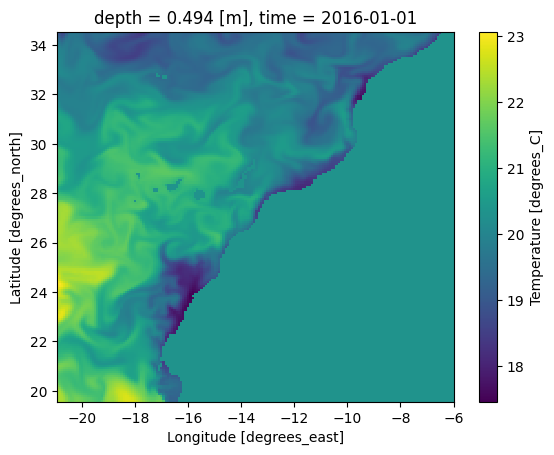

In [9]:
ds_sst_interp_noNan.isel(time=0, depth=0).plot()

In [10]:
ds_sst_interp.data.shape

(2, 1, 361, 720)

In [11]:
import numpy as np
import torch

from aurora import Batch, Metadata

# Load these pressure levels.
levels = (1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50)


def load_surf(v: str, v_in_file: str) -> torch.Tensor:
    """Load the downloaded surface-level or static variable `v` for hours 00 and 06."""
    ds = xr.open_dataset(download_path / date.strftime(f"surf_{v}_%Y-%m-%d.grib"), engine="cfgrib")
    data = ds[v_in_file].values[:2]  # Use hours 00 and 06.
    data = data[None]  # Insert a batch dimension.
    return torch.from_numpy(data)


def load_atmos(v: str) -> torch.Tensor:
    """Load the downloaded atmospheric variable `v` for hours 00 and 06."""
    ds_00 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_00.grib"), engine="cfgrib"
    )
    ds_06 = xr.open_dataset(
        download_path / date.strftime(f"atmos_{v}_%Y-%m-%d_06.grib"), engine="cfgrib"
    )
    # Select the right pressure levels.
    ds_00 = ds_00[v].sel(isobaricInhPa=list(levels))
    ds_06 = ds_06[v].sel(isobaricInhPa=list(levels))
    data = np.stack((ds_00.values, ds_06.values), axis=0)
    data = data[None]  # Insert a batch dimension.
    return torch.from_numpy(data)


# Extract the latitude and longitude from an arbitrary downloaded file.
ds = xr.open_dataset(next(iter(downloads.keys())), engine="cfgrib")

batch = Batch(
    surf_vars={
        "2t": load_surf("2t", "t2m"),
        "10u": load_surf("10u", "u10"),
        "10v": load_surf("10v", "v10"),
        "msl": load_surf("msl", "msl"),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time.
        "z": load_surf("z", "z")[0, 0],
        "slt": load_surf("slt", "slt")[0, 0],
        "lsm": load_surf("lsm", "lsm")[0, 0],
    },
    atmos_vars={
        "t": load_atmos("t"),
        "u": load_atmos("u"),
        "v": load_atmos("v"),
        "q": load_atmos("q"),
        "z": load_atmos("z"),
    },
    metadata=Metadata(
        lat=torch.from_numpy(ds.latitude.values),
        lon=torch.from_numpy(ds.longitude.values),
        time=(date.replace(hour=6),),
        atmos_levels=levels,
    ),
)

In [12]:
batch = batch.regrid(res=0.5)

In [13]:
x = torch.from_numpy(ds_sst_interp_noNan.data)
batch.surf_vars["2t"] = torch.permute(x, (1, 0, 2, 3))

**Resultado:**
Los datos del lote han sido reemplazados por los datos específicos del caso de estudio tras la interpolación y adaptación.


## Inferencia con el modelo Aurora

El modelo preentrenado se utiliza para realizar predicciones sobre los datos adaptados.



In [14]:
from aurora import AuroraHighRes, rollout

model = AuroraHighRes()
    # Use manually downloaded and regridded static variables)
model.load_checkpoint("microsoft/aurora", "aurora-0.1-finetuned.ckpt")

model.eval()
model = model.to("cuda")

with torch.inference_mode():
    preds = [pred.to("cpu") for pred in rollout(model, batch, steps=2)]

model = model.to("cpu")

c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\aurora\model\perceiver.py:136: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  out = F.scaled_dot_product_attention(q, k, v)


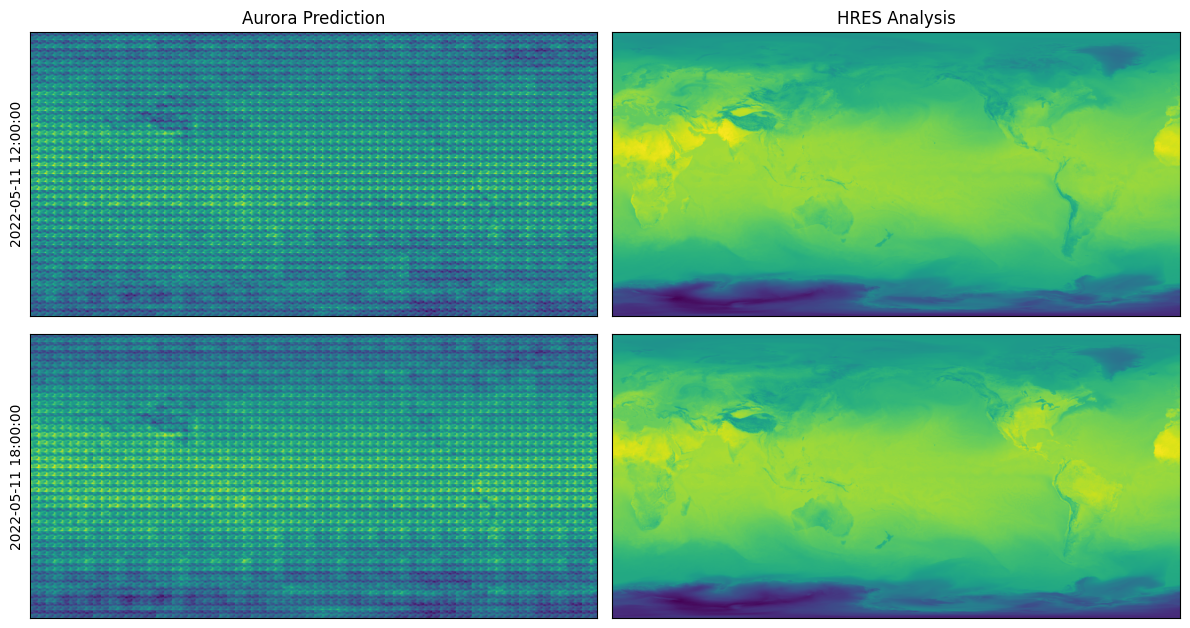

In [15]:
import matplotlib.pyplot as plt

truth = xr.open_dataset(download_path / date.strftime("surf_2t_%Y-%m-%d.grib"), engine="cfgrib")

fig, ax = plt.subplots(2, 2, figsize=(12, 6.5))

for i in range(ax.shape[0]):
    pred = preds[i]

    #ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy() - 273.15, vmin=-50, vmax=50)
    ax[i, 0].imshow(pred.surf_vars["2t"][0, 0].numpy())
    ax[i, 0].set_ylabel(str(pred.metadata.time[0]))
    if i == 0:
        ax[i, 0].set_title("Aurora Prediction")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])

    ref = truth["t2m"][2 + i].values
    #ax[i, 1].imshow(ref - 273.15, vmin=-50, vmax=50)
    ax[i, 1].imshow(ref)
    if i == 0:
        ax[i, 1].set_title("HRES Analysis")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])

plt.tight_layout()

## Conclusión

El modelo Aurora es capaz de realizar inferencias precisas a partir de datos de análisis atmosféricos. Sin embargo, fue necesario reducir la resolución y adaptar los datos para que fueran compatibles con los recursos disponibles. Las predicciones muestran patrones globales coherentes con los datos reales, aunque pueden requerirse ajustes adicionales para mejorar la precisión en ciertos contextos.
